# Processing Hanna 2020

### Data Filters
1. pdna or etp > mean pdna -3 std
2. sgRNAs targetting essential genes in AACC03

In [1]:
import pandas as pd
import gpplot
import seaborn as sns
import matplotlib.pyplot as plt
import poola.core as pool

from core import add_transform_col

In [2]:
aacc03_reads = pd.read_csv('../data/raw/Hanna2020_aacc03_be39_reads.csv')
aacc03_annotations = pd.read_csv('../data/raw/Hanna2020_aacc03_annotations.csv')
aacc03_tp_genes = ['EEF2', 'HNRNPU', 'PELP1', 'TFRC', 'SF3B1', 'PSMA6', 'KPNB1', 'SNRPD1', 'RPS20', 'POLR1C']
aacc03_fp_genes = ['CD81', 'CD33', 'FAS', 'ICAM1']

## AACC03

In [3]:
aacc03_read_cols = ['pDNA', 'A375_Dropout_RepA', 'A375_Dropout_RepB',
                    'MELJUSO_Dropout_RepA', 'MELJUSO_Dropout_RepB',
                    'OVCAR8_Dropout_RepA', 'OVCAR8_Dropout_RepB',
                    'HA1E_Dropout_RepA', 'HA1E_Dropout_RepB',
                    'HAP1_Dropout_RepA', 'HAP1_Dropout_RepB']
aacc03_lognorms = pool.lognorm_columns(reads_df=aacc03_reads.drop(['A375_Vemurafenib_RepA',
                                                                   'A375_Vemurafenib_RepB'], axis=1),
                                       columns=aacc03_read_cols)
aacc03_filtered_lognorms = pool.filter_pdna(lognorm_df=aacc03_lognorms, pdna_cols=['pDNA'], z_low=-3)
print('pDNA Filtered: ' + str(aacc03_lognorms.shape[0] - aacc03_filtered_lognorms.shape[0]))

pDNA Filtered: 70


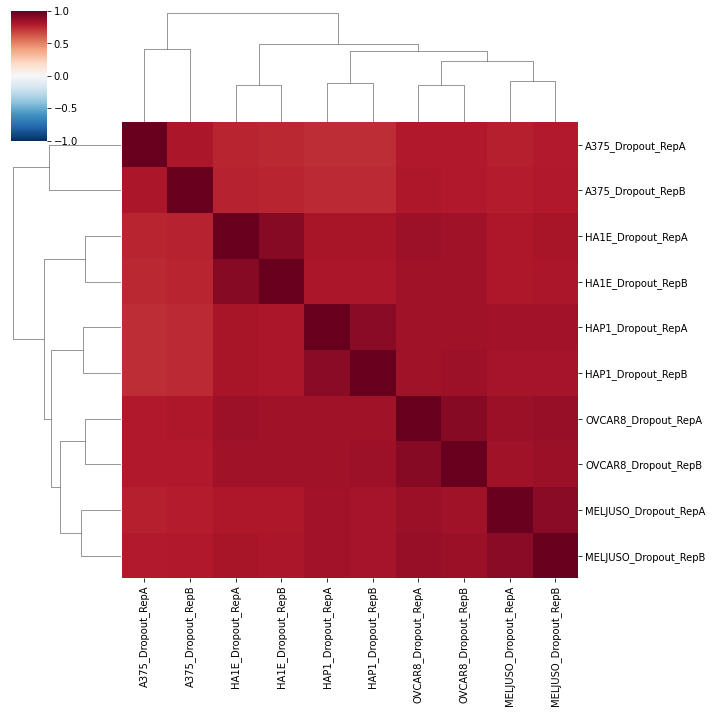

In [4]:
aacc03_read_cols.remove('pDNA')
aacc03_lfc_df = pool.calculate_lfcs(lognorm_df=aacc03_filtered_lognorms, ref_col='pDNA',
                                    target_cols=aacc03_read_cols)
aacc03_cors = aacc03_lfc_df.corr()
sns.clustermap(aacc03_cors, cmap='RdBu_r', vmin=-1, vmax=1)

In [5]:
aacc03_long_cors = (aacc03_cors.reset_index()
                    .rename({'index': 'condition_rep1'}, axis=1)
                    .melt(id_vars='condition_rep1',
                          var_name='condition_rep2', value_name='r'))
aacc03_long_cors[['condition1', 'rep1']] = aacc03_long_cors['condition_rep1'].str.split('_', expand=True)[[0, 2]]
aacc03_long_cors[['condition2', 'rep2']] = aacc03_long_cors['condition_rep2'].str.split('_', expand=True)[[0, 2]]
filtered_cors = aacc03_long_cors[(aacc03_long_cors['condition1'] == aacc03_long_cors['condition2']) &
                          (aacc03_long_cors['rep1'] != aacc03_long_cors['rep2'])]
mean_pearson = filtered_cors['r'].mean()
print('Mean correlation: ' + str(round(mean_pearson, 4)))

Mean correlation: 0.8872


In [6]:
aacc03_sg_list = list(aacc03_lfc_df['sgRNA sequence'].unique())
aacc03_design_df = pd.read_parquet('/Volumes/GoogleDrive/Shared drives/GPP Cloud /R&D/People/Peter/gpp-annotation-files/sgRNA_design_9606_GRCh38_SpyoCas9_CRISPRko_Ensembl_20200401.parquet',
                                   filters=[[('sgRNA Sequence', 'in', aacc03_sg_list)]])

In [7]:
aacc03_avg_replicate_lfc_df = pool.average_replicate_lfcs(lfcs=aacc03_lfc_df, guide_col='sgRNA sequence',
                                                          condition_indices=[0], sep='_')

In [8]:
aacc03_design_df['Transcript Base'] = aacc03_design_df['Target Transcript'].str.split('.', expand=True)[0]
aacc03_lfcs_designs = (aacc03_avg_replicate_lfc_df
                       .merge(aacc03_annotations, how = 'inner', on = 'sgRNA sequence')
                       .rename({'sgRNA sequence': 'sgRNA Sequence',
                                'sgRNA context sequence': 'sgRNA Context Sequence',
                                'Gene symbol': 'Target Gene Symbol',
                                'Ensembl transcript ID': 'Transcript Base',
                                'Ensembl gene ID': 'Target Gene ID',
                                'sgRNA strand': 'Orientation'}, axis=1)
                       .merge(aacc03_design_df, how='inner',
                              on=['sgRNA Sequence', 'sgRNA Context Sequence',
                                  'Target Gene Symbol', 'Transcript Base',
                                  'Target Gene ID', 'Orientation']))
aacc03_roc_aucs, _ = pool.get_roc_aucs(lfcs=aacc03_lfcs_designs[(aacc03_lfcs_designs['Mutation category'].str
                                                          .contains('Missense|Nonsense', na=False))],
                                tp_genes=aacc03_tp_genes,
                                fp_genes=aacc03_fp_genes, gene_col='Target Gene Symbol',
                                score_col='avg_lfc', condition_col='condition')
aacc03_roc_aucs

,condition,ROC-AUC
0,A375,0.611197
1,HA1E,0.629571
2,HAP1,0.667728
3,MELJUSO,0.654587
4,OVCAR8,0.647893


In [9]:
aacc03_roc_aucs['ROC-AUC'].mean()

0.6421953732929788

In [10]:
aacc03_relevant_sgs_designs = aacc03_lfcs_designs[aacc03_lfcs_designs['Target Gene Symbol'].isin(aacc03_tp_genes)]
aacc03_filtered_sgs = aacc03_relevant_sgs_designs[(aacc03_relevant_sgs_designs['# Off-Target Tier I Match Bin I Matches'] == '0')].copy()
print('Off target filtered: ' + str(aacc03_relevant_sgs_designs.shape[0] - aacc03_filtered_sgs.shape[0]))

Off target filtered: 275


In [11]:
aacc03_filtered_sgs['neg_lfc'] = -aacc03_filtered_sgs['avg_lfc']
aacc03_filtered_sgs = add_transform_col(df=aacc03_filtered_sgs,
                                 col='neg_lfc',
                                 transform_name='yeo-johnson',
                                 transformed_name='scaled_neg_lfc',
                                 group_col=['Target Gene Symbol', 'condition'])
aacc03_sg_avg_score = (aacc03_filtered_sgs.groupby(['sgRNA Sequence', 'sgRNA Context Sequence', 'Target Gene Symbol',
                                     'Target Cut %', 'On-Target Efficacy Score'])
                .agg({'scaled_neg_lfc': 'mean'})
                .reset_index())
aacc03_sg_avg_score['scaled_neg_lfc'] = ((aacc03_sg_avg_score['scaled_neg_lfc'] - aacc03_sg_avg_score['scaled_neg_lfc'].mean())/
                                  aacc03_sg_avg_score['scaled_neg_lfc'].std())

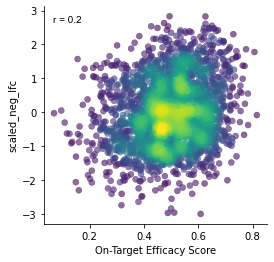

In [12]:
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=aacc03_sg_avg_score,
                         y='scaled_neg_lfc', x='On-Target Efficacy Score')
gpplot.add_correlation(data=aacc03_sg_avg_score,
                       y='scaled_neg_lfc', x='On-Target Efficacy Score')
sns.despine()

In [13]:
aacc03_training_data = aacc03_sg_avg_score.drop('On-Target Efficacy Score', axis=1)
aacc03_training_data

,sgRNA Sequence,sgRNA Context Sequence,Target Gene Symbol,Target Cut %,scaled_neg_lfc
0,AAAAAATTATGCTGAATACC,GATTAAAAAATTATGCTGAATACCAGGTAG,KPNB1,75.6,0.988858
1,AAAACAGGGGCACGAGGGTA,AGGAAAAACAGGGGCACGAGGGTATGGATA,HNRNPU,91.0,-1.111856
2,AAAACCGGCGCTGGAACCAC,GGTCAAAACCGGCGCTGGAACCACGGGACA,PSMA6,1.3,1.052915
3,AAAACTATCAAGTTGGGATC,CCAAAAAACTATCAAGTTGGGATCAGGCAG,SF3B1,16.7,-0.606245
4,AAAACTCTTGGAGCAATATA,CCCAAAAACTCTTGGAGCAATATAAGGAAG,HNRNPU,80.5,1.107731
...,...,...,...,...,...
2398,TTTGGCAGCTGTGGGCTTAG,TTTGTTTGGCAGCTGTGGGCTTAGTGGGAG,KPNB1,76.7,-1.262632
2399,TTTGGCCATTGAAGCTTCAG,TGGATTTGGCCATTGAAGCTTCAGAGGTGA,KPNB1,33.9,-0.175935
2400,TTTGTATATAAATGCCTTAC,ATCTTTTGTATATAAATGCCTTACTGGGAT,HNRNPU,40.5,0.529085
2401,TTTGTCCAGGAAGTTGTCCA,ACAATTTGTCCAGGAAGTTGTCCAGGGCAG,EEF2,99.1,-0.203730


In [14]:
aacc03_training_data.to_csv('../data/processed/Hanna2020_aacc03_activity.csv', index=False)